# Solving a HANK with ex-ante heterogeneity in discount rates
Carroll, Slacalek, Tokuoka, White (2017) show that by  having ex-ante hetoerogeneity in discount rates, you can match the Lorenz curve relatively well. Check out a [demonstration](https://github.com/econ-ark/DemARK/blob/master/notebooks/Micro-and-Macro-Implications-of-Very-Impatient-HHs.ipynb) or [replication](https://github.com/econ-ark/DistributionOfWealthMPC) for details.

In [1]:
from ConsIndShockModel_HANK_latest_12_14_2022 import IndShockConsumerType
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict, UserProvidedSS
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import matplotlib.pyplot as plt
import math
import numpy as np
import pickle
import xarray as xr
import time
from scipy import stats
from scipy.special import erf, erfc
from warnings import warn
from tqdm import tqdm
from copy import copy, deepcopy
from itertools import product

from scipy import optimize

In [2]:
class Distribution:
    """
    Base class for all probability distributions.
    Parameters
    ----------
    seed : int
        Seed for random number generator.
    """

    def __init__(self, seed=0):
        self.RNG = np.random.RandomState(seed)
        self.seed = seed

    def reset(self):
        """
        Reset the random number generator of this distribution.
        Parameters
        ----------
        """
        self.RNG = np.random.RandomState(self.seed)

In [3]:
class Uniform(Distribution):
    """
    A Uniform distribution.
    Parameters
    ----------
    bot : float or [float]
        One or more bottom values.
        Number of elements T in mu determines number
        of rows of output.
    top : float or [float]
        One or more top values.
        Number of elements T in top determines number of
        rows of output.
    seed : int
        Seed for random number generator.
    """

    bot = None
    top = None

    def __init__(self, bot=0.0, top=1.0, seed=0):
        self.bot = np.array(bot)
        self.top = np.array(top)
        # Set up the RNG
        self.RNG = np.random.RandomState(seed)

    def draw(self, N):
        """
        Generate arrays of uniform draws.  The bot and top inputs can be numbers or
        list-likes.  If a number, output is a length N array of draws from the
        uniform distribution on [bot,top]. If a list, output is a length T list
        whose t-th entry is a length N array with draws from the uniform distribution
        on [bot[t],top[t]].
        Parameters
        ----------
        N : int
            Number of draws in each row.
        Returns
        -------
        draws : np.array or [np.array]
            T-length list of arrays of uniform draws each of size N, or a single
            array of size N (if sigma is a scalar).
        """
        draws = []
        for j in range(self.bot.size):
            draws.append(
                self.bot.item(j)
                + (self.top.item(j) - self.bot.item(j)) * self.RNG.rand(N)
            )
        return draws[0] if len(draws) == 1 else draws

    def approx(self, N, endpoint=False):
        """
        Makes a discrete approximation to this uniform distribution.
        Parameters
        ----------
        N : int
            The number of points in the discrete approximation.
        endpoint : bool
            Whether to include the endpoints in the approximation.
        Returns
        -------
        d : DiscreteDistribution
            Probability associated with each point in array of discrete
            points for discrete probability mass function.
        """
        pmv = np.ones(N) / float(N)

        center = (self.top + self.bot) / 2.0
        width = (self.top - self.bot) / 2.0
        atoms = center + width * np.linspace(-(N - 1.0) / 2.0, (N - 1.0) / 2.0, N) / (
            N / 2.0
        )

        if endpoint:  # insert endpoints with infinitesimally small mass
            atoms = np.concatenate(([self.bot], atoms, [self.top]))
            pmv = np.concatenate(([0.0], pmv, [0.0]))

        return DiscreteDistribution(
            pmv, atoms, seed=self.RNG.randint(0, 2**31 - 1, dtype="int32")
        )

In [4]:
class DiscreteDistribution(Distribution):
    """
    A representation of a discrete probability distribution.
    Parameters
    ----------
    pmv : np.array
        An array of floats representing a probability mass function.
    atoms : np.array
        Discrete point values for each probability mass.
        For multivariate distributions, the last dimension of atoms must index
        "atom" or the random realization. For instance, if atoms.shape == (2,6,4),
        the random variable has 4 possible realizations and each of them has shape (2,6).
    seed : int
        Seed for random number generator.
    """

    pmv = None
    atoms = None

    def __init__(self, pmv, atoms, seed=0):

        self.pmv = pmv

        if len(atoms.shape) < 2:
            self.atoms = atoms[None, ...]
        else:
            self.atoms = atoms

        # Set up the RNG
        super().__init__(seed)

        # Check that pmv and atoms have compatible dimensions.
        same_dims = len(pmv) == atoms.shape[-1]
        if not same_dims:
            raise ValueError(
                "Provided pmv and atoms arrays have incompatible dimensions. "
                + "The length of the pmv must be equal to that of atoms's last dimension."
            )

    def dim(self):
        """
        Last dimension of self.atoms indexes "atom."
        """
        return self.atoms.shape[:-1]

    def draw_events(self, n):
        """
        Draws N 'events' from the distribution PMF.
        These events are indices into atoms.
        """
        # Generate a cumulative distribution
        base_draws = self.RNG.uniform(size=n)
        cum_dist = np.cumsum(self.pmv)

        # Convert the basic uniform draws into discrete draws
        indices = cum_dist.searchsorted(base_draws)

        return indices

    def draw(self, N, atoms=None, exact_match=False):
        """
        Simulates N draws from a discrete distribution with probabilities P and outcomes atoms.
        Parameters
        ----------
        N : int
            Number of draws to simulate.
        atoms : None, int, or np.array
            If None, then use this distribution's atoms for point values.
            If an int, then the index of atoms for the point values.
            If an np.array, use the array for the point values.
        exact_match : boolean
            Whether the draws should "exactly" match the discrete distribution (as
            closely as possible given finite draws).  When True, returned draws are
            a random permutation of the N-length list that best fits the discrete
            distribution.  When False (default), each draw is independent from the
            others and the result could deviate from the input.
        Returns
        -------
        draws : np.array
            An array of draws from the discrete distribution; each element is a value in atoms.
        """
        if atoms is None:
            atoms = self.atoms
        elif isinstance(atoms, int):
            atoms = self.atoms[atoms]

        if exact_match:
            events = np.arange(self.pmv.size)  # just a list of integers
            cutoffs = np.round(np.cumsum(self.pmv) * N).astype(
                int
            )  # cutoff points between discrete outcomes
            top = 0

            # Make a list of event indices that closely matches the discrete distribution
            event_list = []
            for j in range(events.size):
                bot = top
                top = cutoffs[j]
                event_list += (top - bot) * [events[j]]

            # Randomly permute the event indices
            indices = self.RNG.permutation(event_list)

        # Draw event indices randomly from the discrete distribution
        else:
            indices = self.draw_events(N)

        # Create and fill in the output array of draws based on the output of event indices
        draws = atoms[..., indices]

        # TODO: some models expect univariate draws to just be a 1d vector. Fix those models.
        if len(draws.shape) == 2 and draws.shape[0] == 1:
            draws = draws.flatten()

        return draws

    def expected(self, func=None, *args):
        """
        Expected value of a function, given an array of configurations of its
        inputs along with a DiscreteDistribution object that specifies the
        probability of each configuration.
        Parameters
        ----------
        func : function
            The function to be evaluated.
            This function should take the full array of distribution values
            and return either arrays of arbitrary shape or scalars.
            It may also take other arguments *args.
            This function differs from the standalone `calc_expectation`
            method in that it uses numpy's vectorization and broadcasting
            rules to avoid costly iteration.
            Note: If you need to use a function that acts on single outcomes
            of the distribution, consier `distribution.calc_expectation`.
        *args :
            Other inputs for func, representing the non-stochastic arguments.
            The the expectation is computed at f(dstn, *args).
        Returns
        -------
        f_exp : np.array or scalar
            The expectation of the function at the queried values.
            Scalar if only one value.
        """

        if func is None:
            # if no function is provided, it's much faster to go straight
            # to dot product instead of calling the dummy function.
            f_query = self.atoms
        else:
            # if a function is provided, we need to add one more dimension,
            # the atom dimension, to any inputs that are n-dim arrays.
            # This allows numpy to easily broadcast the function's output.
            # For more information on broadcasting, see:
            # https://numpy.org/doc/stable/user/basics.broadcasting.html#general-broadcasting-rules
            args = [
                arg[..., np.newaxis] if isinstance(arg, np.ndarray) else arg
                for arg in args
            ]

            f_query = func(self.atoms, *args)

        f_exp = np.dot(f_query, self.pmv)

        return f_exp

    def dist_of_func(self, func=lambda x: x, *args):
        """
        Finds the distribution of a random variable Y that is a function
        of discrete random variable atoms, Y=f(atoms).
        Parameters
        ----------
        func : function
            The function to be evaluated.
            This function should take the full array of distribution values.
            It may also take other arguments *args.
        *args :
            Additional non-stochastic arguments for func,
            The function is computed as f(dstn, *args).
        Returns
        -------
        f_dstn : DiscreteDistribution
            The distribution of func(dstn).
        """
        # we need to add one more dimension,
        # the atom dimension, to any inputs that are n-dim arrays.
        # This allows numpy to easily broadcast the function's output.
        args = [
            arg[..., np.newaxis] if isinstance(arg, np.ndarray) else arg for arg in args
        ]
        f_query = func(self.atoms, *args)

        f_dstn = DiscreteDistribution(list(self.pmv), f_query, seed=self.seed)

        return f_dstn

In [5]:
# Define a dictionary with calibrated parameters
tau = 0
Y_ss = 1
T_ss = 0
cstwMPC_calibrated_parameters = {
    "CRRA": 1.0,  # Coefficient of relative risk aversion
    "Rfree": 1.01 / (1.0 - 1.0 / 160.0),  # Survival probability,
    "PermGroFac": [1.000**0.25],  # Permanent income growth factor (no perm growth),
    "PermGroFacAgg": 1.0,
    "BoroCnstArt": 0.0,
    "CubicBool": False,
    "vFuncBool": False,
    "PermShkStd": [(0.01 * 4 / 11) ** 0.5    ],  # Standard deviation of permanent shocks to income
    "PermShkCount": 5,  # Number of points in permanent income shock grid
    "TranShkStd": [
        (0.01 * 4) ** 0.5
    ],  # Standard deviation of transitory shocks to income,
    "TranShkCount": 5,  # Number of points in transitory income shock grid
    "UnempPrb": 0.07,  # Probability of unemployment while working
    "IncUnemp": 0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet": 0.07,
    "IncUnempRet": 0.15,
    "aXtraMin": 0.00001,  # Minimum end-of-period assets in grid
    "aXtraMax": 1000000,  # Maximum end-of-period assets in grid
    "aXtraCount": 500,  # Number of points in assets grid
    "aXtraExtra": [None],
    "aXtraNestFac": 3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb": [1.0 - 1.0 / 160.0],  # Survival probability
    "DiscFac": 0.97,  # Default intertemporal discount factor; dummy value, will be overwritten
    "cycles": 0,
    "T_cycle": 1,
    "T_retire": 0,
    "T_sim": 1200,  # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    "T_age": 400,
    "IndL": 10.0 / 9.0,  # Labor supply per individual (constant),
    "aNrmInitMean": np.log(0.00001),
    "aNrmInitStd": 0.0,
    "pLvlInitMean": 0.0,
    "pLvlInitStd": 0.0,
    "AgentCount": 10000,
    
    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],
    
    # Transition Matrix simulation parameters
    "mCount": 1300,
    "mMax": 1000000,
    "mMin": 0.0001,
    "mFac": 2,
    
    
    "labor":[1.0],
    "wage":[1.0],
    "tax_rate": [1.0],
}

# to add taxes, labor and wage
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

cstwMPC_calibrated_parameters['TranShkMean_Func'] = [function]

T = 300

In [6]:



def function(taxrate,labor,wage):
    
    z = (1 - taxrate)*labor*wage
    
    return z


cstwMPC_calibrated_parameters['TranShkMean_Func'] = [function]
# This cell constructs seven instances of IndShockConsumerType with different discount factors
BaselineType = IndShockConsumerType(**cstwMPC_calibrated_parameters)

# Specify the distribution of the discount factor
num_types = 7  # number of types we want
DiscFac_mean = 0.9855583  # center of beta distribution
DiscFac_spread = 0.0085  # spread of beta distribution
DiscFac_dstn = (
    Uniform(DiscFac_mean - DiscFac_spread, DiscFac_mean + DiscFac_spread)
    .approx(num_types)
    .atoms.flatten()
)

print(DiscFac_dstn)

[0.97827259 0.98070116 0.98312973 0.9855583  0.98798687 0.99041544
 0.99284401]


In [7]:
MyTypes = []  # initialize an empty list to hold our consumer types
for nn in range(num_types):
    # Now create the types, and append them to the list MyTypes
    NewType = deepcopy(BaselineType)
    NewType.DiscFac = DiscFac_dstn[nn]
    NewType.seed = nn  # give each consumer type a different RNG seed
    MyTypes.append(NewType)

In [8]:
# Progress bar keeps track interactively of how many have been made
for ThisType in tqdm(MyTypes):
    ThisType.solve()
    ThisType.initialize_sim()
    ThisType.simulate()

  0%|                                                     | 0/7 [00:00<?, ?it/s]GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
 14%|██████▍                                      | 1/7 [00:11<01:11, 11.88s/it]GPFRaw                 = 0.996738 
GPFNrm                 = 0.999994 
GPFAggLivPrb           = 0.990508 
Thorn = APF            = 0.996738 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974572 
WRPF                   = 0.068220 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
 29%|████████████▊                                | 2/7 [00:24<01:00, 12.03s/it]GPFRaw                 = 0.999206 
GPFNrm                 = 

In [9]:
# Baseline Type
BaselineType.solve()
BaselineType.initialize_sim()
BaselineType.simulate()

GPFRaw                 = 0.985862 
GPFNrm                 = 0.989082 
GPFAggLivPrb           = 0.979700 
Thorn = APF            = 0.985862 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


{}

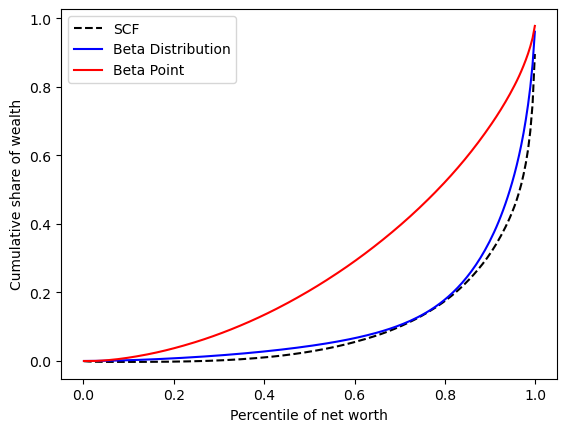

In [10]:
# Plot Lorenz curves for model with uniform distribution of time preference
from HARK.datasets import load_SCF_wealth_weights
from HARK.utilities import get_lorenz_shares, get_percentiles

SCF_wealth, SCF_weights = load_SCF_wealth_weights()

pctiles = np.linspace(0.001, 0.999, 200)
sim_wealth = np.concatenate([ThisType.state_now["aLvl"] for ThisType in MyTypes])
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)
sim_wealth_Baseline = BaselineType.state_now["aLvl"]
sim_Lorenz_Baseline_points = get_lorenz_shares(sim_wealth_Baseline, percentiles=pctiles)

plt.plot(pctiles, SCF_Lorenz_points, "--k", label = "SCF")
plt.plot(pctiles, sim_Lorenz_points, "-b", label = "Beta Distribution")
plt.plot(pctiles, sim_Lorenz_Baseline_points, "-r", label = "Beta Point")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend()
plt.show(block=False)

# Create Jacobians

In [11]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[6]
Agent_7 = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)

In [12]:
Agent_7.compute_steady_state()

GPFRaw                 = 1.009079 
GPFNrm                 = 1.012375 
GPFAggLivPrb           = 1.002772 
Thorn = APF            = 1.009079 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.986639 
WRPF                   = 0.069065 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(70.28290201236337, 1.7024264890508054)

In [13]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[6]
Agent_7_labor = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)
Agent_7_labor.compute_steady_state()
CJAC_labor_7, AJACR_labor_7= Agent_7_labor.calc_jacobian('labor',T)


GPFRaw                 = 1.009079 
GPFNrm                 = 1.012375 
GPFAggLivPrb           = 1.002772 
Thorn = APF            = 1.009079 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.986639 
WRPF                   = 0.069065 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


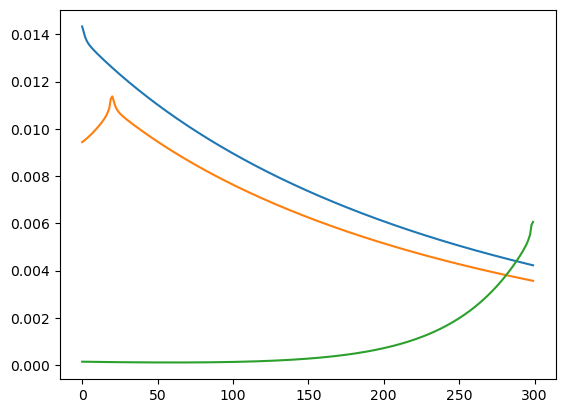

In [14]:
plt.plot(CJAC_labor_7.T[0])
plt.plot(CJAC_labor_7.T[20])
plt.plot(CJAC_labor_7.T[-1])
plt.show()

In [15]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[5]
Agent_6_labor = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)
Agent_6_labor.compute_steady_state()
CJAC_labor_6, AJACR_labor_6 = Agent_6_labor.calc_jacobian('labor',T)


GPFRaw                 = 1.006611 
GPFNrm                 = 1.009899 
GPFAggLivPrb           = 1.000320 
Thorn = APF            = 1.006611 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.984225 
WRPF                   = 0.068896 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


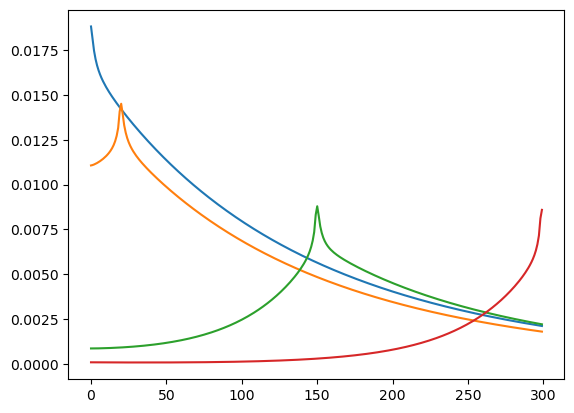

In [16]:
plt.plot(CJAC_labor_6.T[0])
plt.plot(CJAC_labor_6.T[20])
plt.plot(CJAC_labor_6.T[150])

plt.plot(CJAC_labor_6.T[-1])
plt.show()

In [17]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[4]
Agent_5_labor = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)
Agent_5_labor.compute_steady_state()
CJAC_labor_5, AJACR_labor_5 = Agent_5_labor.calc_jacobian('labor',T)


GPFRaw                 = 1.004143 
GPFNrm                 = 1.007423 
GPFAggLivPrb           = 0.997867 
Thorn = APF            = 1.004143 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.981812 
WRPF                   = 0.068727 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


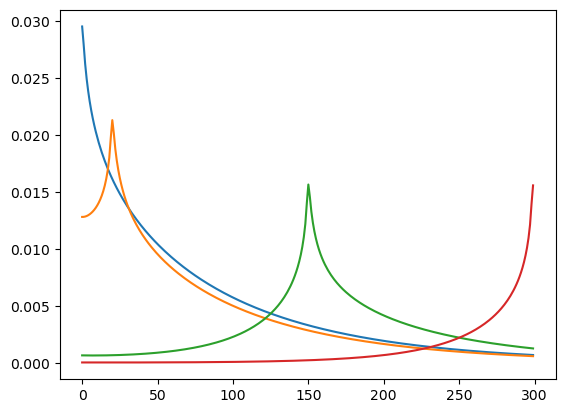

In [18]:
plt.plot(CJAC_labor_5.T[0])
plt.plot(CJAC_labor_5.T[20])
plt.plot(CJAC_labor_5.T[150])

plt.plot(CJAC_labor_5.T[-1])
plt.show()

In [19]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[3]
Agent_4_labor = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)
Agent_4_labor.compute_steady_state()
CJAC_labor_4, AJACR_labor_4 = Agent_4_labor.calc_jacobian('labor',T)


GPFRaw                 = 1.001674 
GPFNrm                 = 1.004946 
GPFAggLivPrb           = 0.995414 
Thorn = APF            = 1.001674 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.979399 
WRPF                   = 0.068558 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


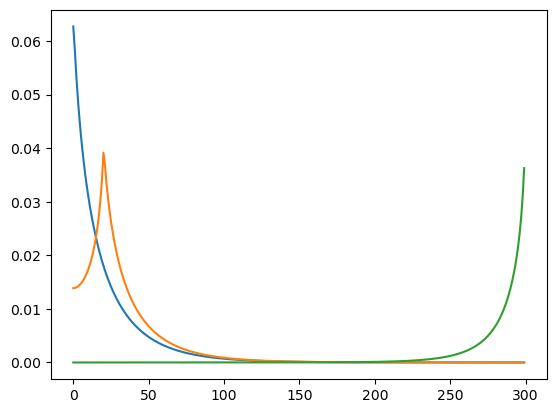

In [20]:
plt.plot(CJAC_labor_4.T[0])
plt.plot(CJAC_labor_4.T[20])
plt.plot(CJAC_labor_4.T[-1])
plt.show()

In [21]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[2]
Agent_3_labor = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)
Agent_3_labor.compute_steady_state()
CJAC_labor_3, AJACR_labor_3= Agent_3_labor.calc_jacobian('labor',T)


GPFRaw                 = 0.999206 
GPFNrm                 = 1.002470 
GPFAggLivPrb           = 0.992961 
Thorn = APF            = 0.999206 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976985 
WRPF                   = 0.068389 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


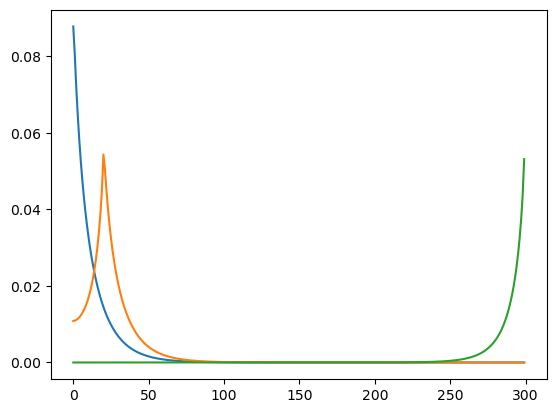

In [22]:
plt.plot(CJAC_labor_3.T[0])
plt.plot(CJAC_labor_3.T[20])
plt.plot(CJAC_labor_3.T[-1])
plt.show()

In [46]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[1]
Agent_2_labor = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)
Agent_2_labor.compute_steady_state()
CJAC_labor_2, AJACR_labor_2= Agent_2_labor.calc_jacobian('labor',T)


GPFRaw                 = 0.996738 
GPFNrm                 = 0.999994 
GPFAggLivPrb           = 0.990508 
Thorn = APF            = 0.996738 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974572 
WRPF                   = 0.068220 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


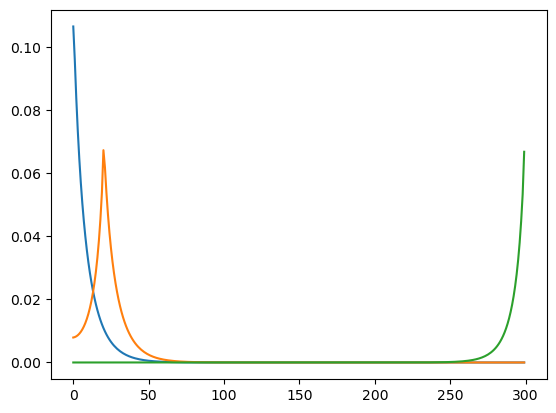

In [50]:
plt.plot(CJAC_labor_2.T[0])
plt.plot(CJAC_labor_2.T[20])
plt.plot(CJAC_labor_2.T[-1])
plt.show()

In [47]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[0]
Agent_1_labor = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)
Agent_1_labor.compute_steady_state()
CJAC_labor_1, AJACR_labor_1= Agent_1_labor.calc_jacobian('labor',T)


GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


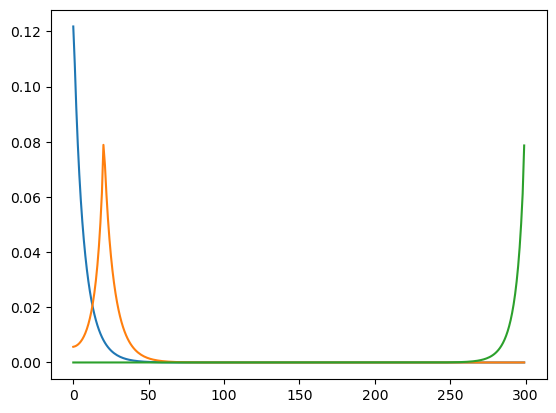

In [51]:
plt.plot(CJAC_labor_1.T[0])
plt.plot(CJAC_labor_1.T[20])
plt.plot(CJAC_labor_1.T[-1])
plt.show()

In [23]:
CJACR7, AJACR7 = Agent_7.calc_jacobian('Rfree',T)
#CJACN7, AJACN7 = MyTypes[6].calc_jacobian('labor',T)

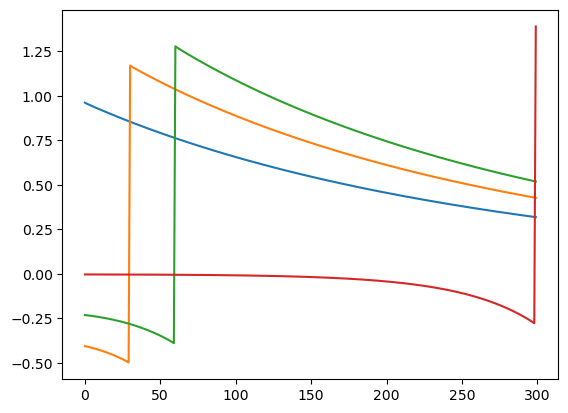

In [24]:
plt.plot(CJACR7.T[0])
plt.plot(CJACR7.T[30])
plt.plot(CJACR7.T[60])
plt.plot(CJACR7.T[-1])

plt.show()

In [25]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[5]
Agent_6 = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)

In [26]:
Agent_6.compute_steady_state()
CJACR6, AJACR6 = Agent_6.calc_jacobian('Rfree',T)

GPFRaw                 = 1.006611 
GPFNrm                 = 1.009899 
GPFAggLivPrb           = 1.000320 
Thorn = APF            = 1.006611 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.984225 
WRPF                   = 0.068896 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


In [27]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[4]
Agent_5 = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)

In [28]:
Agent_5.compute_steady_state()
CJACR5, AJACR5 = Agent_5.calc_jacobian('Rfree',T)

GPFRaw                 = 1.004143 
GPFNrm                 = 1.007423 
GPFAggLivPrb           = 0.997867 
Thorn = APF            = 1.004143 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.981812 
WRPF                   = 0.068727 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


In [29]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[3]
Agent_4 = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)

In [30]:
Agent_4.compute_steady_state()
CJACR4, AJACR4 = Agent_4.calc_jacobian('Rfree',T)

GPFRaw                 = 1.001674 
GPFNrm                 = 1.004946 
GPFAggLivPrb           = 0.995414 
Thorn = APF            = 1.001674 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.979399 
WRPF                   = 0.068558 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


In [31]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[2]
Agent_3 = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)

In [32]:
Agent_3.compute_steady_state()
CJACR3, AJACR3 = Agent_3.calc_jacobian('Rfree',T)

GPFRaw                 = 0.999206 
GPFNrm                 = 1.002470 
GPFAggLivPrb           = 0.992961 
Thorn = APF            = 0.999206 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976985 
WRPF                   = 0.068389 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


In [33]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[1]
Agent_2 = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)

In [34]:
Agent_2.compute_steady_state()
CJACR2, AJACR2 = Agent_2.calc_jacobian('Rfree',T)

GPFRaw                 = 0.996738 
GPFNrm                 = 0.999994 
GPFAggLivPrb           = 0.990508 
Thorn = APF            = 0.996738 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974572 
WRPF                   = 0.068220 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


In [35]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[0]
Agent_1 = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)

In [36]:
Agent_1.compute_steady_state()
CJACR1, AJACR1 = Agent_1.calc_jacobian('Rfree',T)

GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


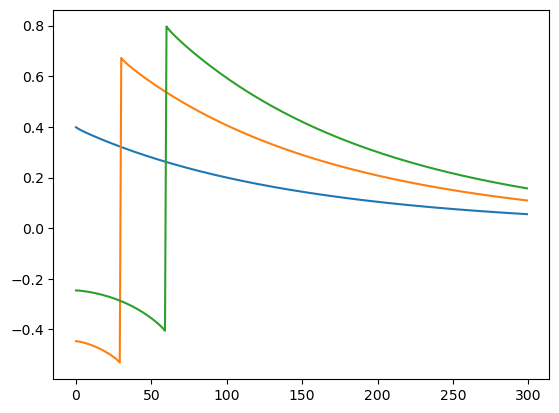

In [37]:
plt.plot(CJACR6.T[0])
plt.plot(CJACR6.T[30])
plt.plot(CJACR6.T[60])
plt.show()

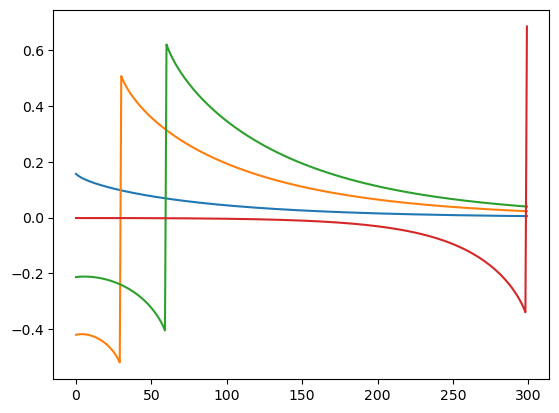

In [38]:
plt.plot(CJACR5.T[0])
plt.plot(CJACR5.T[30])
plt.plot(CJACR5.T[60])
plt.plot(CJACR5.T[-1])
plt.show()

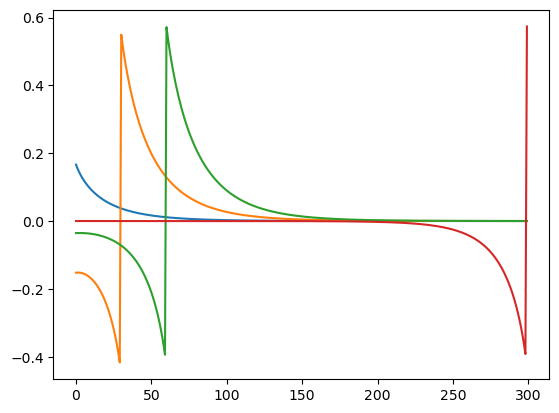

In [39]:
plt.plot(CJACR4.T[0])
plt.plot(CJACR4.T[30])
plt.plot(CJACR4.T[60])
plt.plot(CJACR4.T[-1])
plt.show()

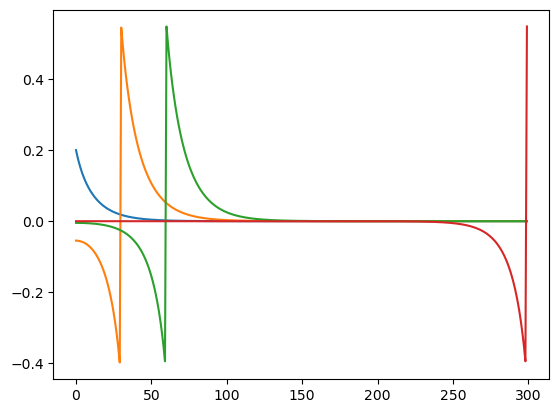

In [40]:
plt.plot(CJACR3.T[0])
plt.plot(CJACR3.T[30])
plt.plot(CJACR3.T[60])
plt.plot(CJACR3.T[-1])
plt.show()

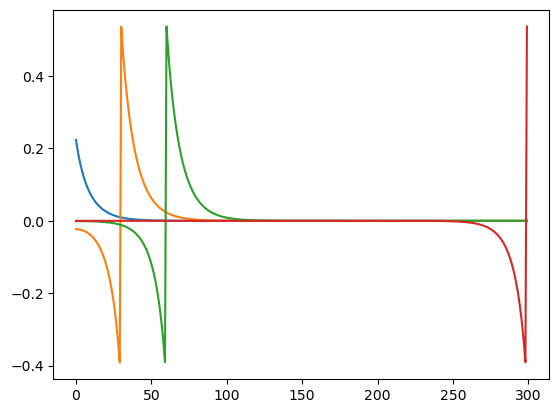

In [41]:
plt.plot(CJACR2.T[0])
plt.plot(CJACR2.T[30])
plt.plot(CJACR2.T[60])
plt.plot(CJACR2.T[-1])
plt.show()

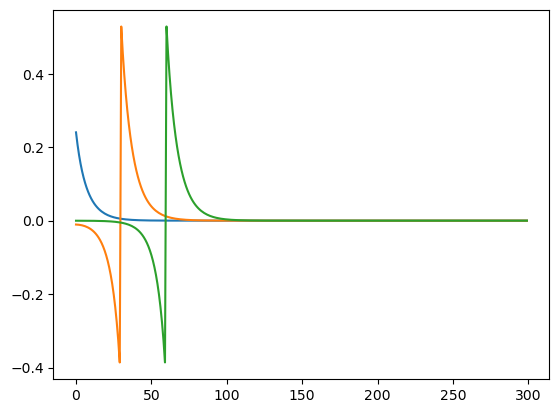

In [42]:
plt.plot(CJACR1.T[0])
plt.plot(CJACR1.T[30])
plt.plot(CJACR1.T[60])
plt.show()

In [48]:
### Combine them
CJACR_het = (CJACR1 + CJACR2 + CJACR3 + CJACR4 + CJACR5 + CJACR6 + CJACR7)/7
CJAClabor_het = (CJAC_labor_1 + CJAC_labor_2 + CJAC_labor_3 + CJAC_labor_4 + CJAC_labor_5 + CJAC_labor_6 + CJAC_labor_7)/7


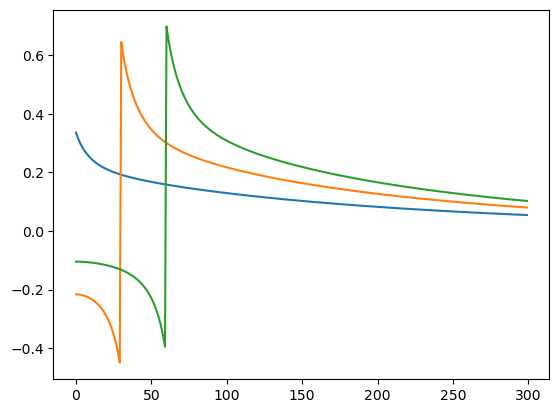

In [44]:
plt.plot(CJACR_het.T[0])
plt.plot(CJACR_het.T[30])
plt.plot(CJACR_het.T[60])
plt.show()

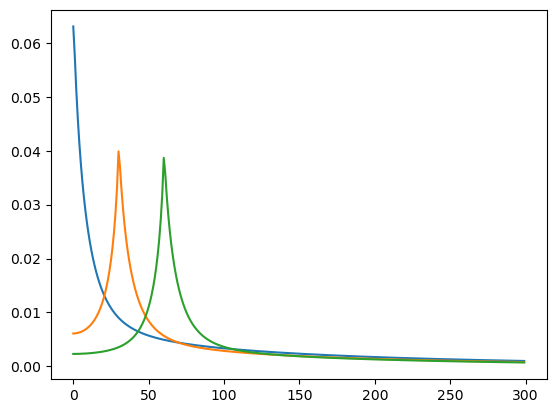

In [49]:
plt.plot(CJAClabor_het.T[0])
plt.plot(CJAClabor_het.T[30])
plt.plot(CJAClabor_het.T[60])
plt.show()

In [45]:
stop

NameError: name 'stop' is not defined

In [ ]:
Agent_1 = IndShockConsumerType(**Dict, verbose = False)

In [ ]:
Dict['DiscFac'] = 0.97
Agent_2 = IndShockConsumerType(**Dict, verbose = False)

In [ ]:
Dict['DiscFac'] = 0.965
Agent_agg = IndShockConsumerType(**Dict, verbose = False)

In [ ]:
Agent_1.compute_steady_state()

In [ ]:
Agent_2.compute_steady_state()

In [ ]:
Agent_agg.compute_steady_state()

In [ ]:
CJACR_1, AJACR_1 = Agent_1.calc_jacobian('Rfree',T)


In [ ]:
CJACR_2, AJACR_2 = Agent_2.calc_jacobian('Rfree',T)


In [ ]:
CJACR_agg, AJACR_agg = Agent_agg.calc_jacobian('Rfree',T)


In [ ]:
plt.plot(CJACR_1.T[0])
plt.plot(CJACR_1.T[10])
plt.plot(CJACR_1.T[30])
plt.plot(CJACR_2.T[0], '--')
plt.plot(CJACR_2.T[10], '--')
plt.plot(CJACR_2.T[30], '--')
plt.plot(CJACR_agg.T[0], '+')
plt.plot(CJACR_agg.T[10], '+')
plt.plot(CJACR_agg.T[30], '+')
plt.show()

In [ ]:
# How to combine Jacobians

In [ ]:
CJACR_test = (0.5*CJACR_1) + (0.5*CJACR_2)
CJACR_test

In [ ]:
CJACR_agg

In [ ]:
plt.plot(CJACR_test.T[0])
plt.plot(CJACR_test.T[10])
plt.plot(CJACR_test.T[30])
plt.plot(CJACR_agg.T[0], '+')
plt.plot(CJACR_agg.T[10], '+')
plt.plot(CJACR_agg.T[30], '+')
plt.show()

In [ ]:
### GE Steady State
# Input: DiscRateFactors
# Output: Steady State Assets and Taxes
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B
    
    return T

### Target only Steady State Asset
def ss_func(B_ss, r, G):
    Tss = fiscal_ss(B_ss, r, G)
    print(T_ss)
    Dict["labor"] = [Y_ss - T_ss]
    Dict["DiscFac"] = 0.96
    Agent_func1 = IndShockConsumerType(**Dict, verbose = False)
    Dict["DiscFac"] = 0.97
    Agent_func2 = IndShockConsumerType(**Dict, verbose = False)
    A_ss1 = Agent_func1.compute_steady_state()[0]
    A_ss2 = Agent_func2.compute_steady_state()[0]
    A_ss = 0.5*A_ss1 + 0.5*A_ss2
    print('A_ss: ' + str(A_ss))
    print('B_ss: ' + str(B_ss))
    return A_ss
    

def ss_dif(B_ss):
    
    return ss_func(B_ss, r_ss, G_ss) - B_ss 

#Asset_target = B_ss
B_ss_new = optimize.brentq(ss_dif,0,2)
print(B_ss_new)



In [ ]:
fiscal_ss(B_ss, r_ss, G_ss)

In [ ]:
B_ss

In [ ]:
r_ss

In [ ]:
G_ss